In [1]:
import numpy as np
import importlib
import matplotlib.pyplot as plt
import os
import shutil

import representation
import kex_data
import kex_headers
import listmode
import petlink
import position
import e7tools

In [ ]:
###### plan
# load sinograms of gate 0 of each phantom
# register data from gate 1 to gate 0 (including randoms)
# add the new data to the sinogram
# double check
# save

In [2]:
sinograms, _ = kex_data.sinograms()

In [2]:
norm_sino, sino_paths = kex_data.norm_sinograms()
dkeys = kex_data.DATA_KEYS
norm_sino = dict(zip(dkeys, norm_sino))

In [3]:
print(sino_paths)

['C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/CylinderPET-00-sino-norm_00.s', 'C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/CylinderPET-01-sino-norm_00.s', 'C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/KanylPET-00-sino-norm_00.s', 'C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms/KanylPET-01-sino-norm_00.s']


In [4]:
#get file paths
src = "/".join(sino_paths[0].split("/")[:-1])
print("folder", src)
mhdrs = []
hdrs = []
sfiles = []
with os.scandir(src) as it:
    for entry in it:
        if entry.is_file():
            if entry.name.endswith('.s'):
                #print("sino entry name:",  entry.name)
                sfiles.append(entry.name)
            if entry.name.endswith('.s.hdr'):
                #print("header entry name:",  entry.name)
                hdrs.append(entry.name)
            if entry.name.endswith('.mhdr'):
                #print("main header entry name:",  entry.name)
                mhdrs.append(entry.name)   
print("sinos", sfiles, "\nhdrs", hdrs, "\nmhdrs", mhdrs) #nicely sorted, according to the dkeys

folder C:/Users/petct/Desktop/Hugo/Code/PythonMEX/normalised_sinograms
sinos ['CylinderPET-00-sino-norm_00.s', 'CylinderPET-01-sino-norm_00.s', 'KanylPET-00-sino-norm_00.s', 'KanylPET-01-sino-norm_00.s'] 
hdrs ['CylinderPET-00-sino-norm_00.s.hdr', 'CylinderPET-01-sino-norm_00.s.hdr', 'KanylPET-00-sino-norm_00.s.hdr', 'KanylPET-01-sino-norm_00.s.hdr'] 
mhdrs ['CylinderPET-00-sino-norm.mhdr', 'CylinderPET-01-sino-norm.mhdr', 'KanylPET-00-sino-norm.mhdr', 'KanylPET-01-sino-norm.mhdr']


In [5]:
mhdrs = dict(zip(dkeys, mhdrs))
hdrs = dict(zip(dkeys, hdrs))
sfiles = dict(zip(dkeys, sfiles))

In [6]:
def prep_folder(dirname, filling):
    if not os.path.exists(dirname):
        os.mkdir(dirname)
    for path in filling:
        shutil.copy(path, dirname, follow_symlinks=True)

In [23]:
for key in dkeys:
    filling = [mhdrs[key], hdrs[key]]
    for k,f in enumerate(filling):
        filling[k] = src + "/" + f
    mc_dir = r"C:/Users/petct/Desktop/Hugo/Code/PythonMEX/motion_corrected"
    prep_folder(mc_dir, filling)

In [8]:
# plan
# motion correction (basically done)
# easy save (to folder, copy headers)
# reconstruct (e7 tools)
# look (plotting)

In [9]:
limo = kex_data.get_listmode()

In [10]:
limo_recon = {key: listmode.get_fov_image_bins(limo[key]) for key in dkeys}

In [11]:
normfactors = kex_data.get_keyed_normfactors()
toflor = {k: v['tof_lor'] for k,v in limo_recon.items()}
is_prompt = {k: v['is_prompt'] for k,v in limo_recon.items()}
limo_norm = {k: listmode.get_norms(toflor[k], is_prompt[k], v) for k,v in normfactors.items()}

In [12]:
fov_limo_norm = {k: v[limo_recon[k]['is_image_fov']] for k,v in limo_norm.items()}
limo_com = {k: position.listmode_center(v['fov_image_bins'], masses=fov_limo_norm[k]) for k,v in limo_recon.items()}

In [13]:
prompts = {k: v['tof_lor'][:, v['is_prompt']] for k,v in limo_recon.items()}

In [14]:
#move gate 1 to gate 0
ref = np.zeros(3)
translation = np.zeros(3)

limo_mix = {}
norm_mix = {}


for dkey,pos in limo_com.items():
    if dkey.endswith('0'):
        ref = pos
        mix = prompts[dkey]
        norms = limo_norm[dkey]
    else:
        translation = ref - pos #move to reference, pos + (ref - pos) = ref + 0
        translation_mm = translation*kex_headers.MM_PER_PIXEL
        moved_toflor, is_fov = representation.move_translation(prompts[dkey], translation_mm)
        norms = listmode.join_gates((norms, limo_norm[dkey][is_fov]))
        mix = listmode.join_gates((mix, moved_toflor[:, is_fov]))
        if dkey.endswith('1'):
            pkey = dkey.split(" ")[0] 
            limo_mix[pkey] = mix
            norm_mix[pkey] = norms

In [15]:
shape = kex_headers.HISTOGRAM_SHAPE_NO_DELAYS
mc_sinograms = {k: listmode.get_histogram(v, shape, weights=norm_mix[k]) for k,v in limo_mix.items()}

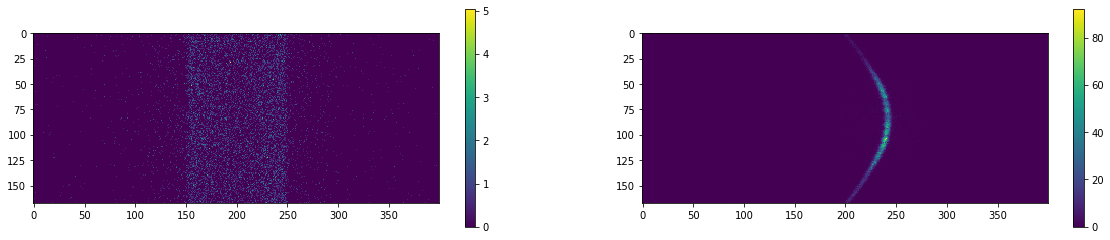

In [28]:
#check before saving and reconstructing
fig, axes = plt.subplots(ncols=2, figsize=(20,4))
axes = dict(zip(kex_data.PHANTOM_KEYS, axes))
for pkey, ax in axes.items():
    tof= 0
    mi = 50
    im = ax.imshow(mc_sinograms[pkey][tof, mi])
    fig.colorbar(im, ax=ax)

In [24]:
#save to ref
ref = 0
for pkey in kex_data.PHANTOM_KEYS:
    dkey = pkey + " " + kex_data.GATE_KEYS[ref]
    output_path = mc_dir + "/" + sfiles[dkey]
    print(output_path)
    with open(output_path, 'wb') as file:
        sino = mc_sinograms[pkey]
        file.write(sino)

C:/Users/petct/Desktop/Hugo/Code/PythonMEX/motion_corrected/CylinderPET-00-sino-norm_00.s
C:/Users/petct/Desktop/Hugo/Code/PythonMEX/motion_corrected/KanylPET-00-sino-norm_00.s


In [32]:
#reconstruct

In [40]:
for pkey in kex_data.PHANTOM_KEYS:
    dkey = pkey + " " + kex_data.GATE_KEYS[ref]
    output_path = mc_dir + "/" + mhdrs[dkey]
    image_path = mc_dir + "/"+pkey
    e7tools.recon(output_path, kex_data.NORM_PATH, image_path, verbose=True)

stdout
 b''
stderr
 b"I 05/26/2020 15:35:21.656 (UTC+01:00) Intel(R) Core(TM) i7-7820HQ CPU @ 2.90GHz (1x)    memory: 32629 MByte
I 05/26/2020 15:35:21.656 (UTC+01:00) Number of NUMA nodes: 1
I 05/26/2020 15:35:21.656 (UTC+01:00) Number of physical processor packages: 1
I 05/26/2020 15:35:21.656 (UTC+01:00) Number of processor cores: 4
I 05/26/2020 15:35:21.656 (UTC+01:00) Number of logical processors: 8
I 05/26/2020 15:35:21.656 (UTC+01:00) Number of processor L1/L2/L3 caches: 8/4/1 
I 05/26/2020 15:35:21.656 (UTC+01:00) Hyper-Threadingin BIOS Enabled.
I 05/26/2020 15:35:21.656 (UTC+01:00)  supported CPU features: MMX,SSE,SSE2,SSE3,SSE4.1,SSE4.2,AVX
I 05/26/2020 15:35:21.928 (UTC+01:00) GPU Driver Version: 24.20.100.6286
I 05/26/2020 15:35:21.929 (UTC+01:00) GPU Driver supported CUDA Version: 9010
I 05/26/2020 15:35:21.929 (UTC+01:00) CUDA Run-time Version Used: 5000
I 05/26/2020 15:35:21.930 (UTC+01:00) Quadro M620 1017 MHz (Compute Capability 5.0)
I 05/26/2020 15:35:21.930 (UTC+01:0